## Makas Yusuf 
## Milioutine David

# TP 2: Déquantification d'image par régularisation $H^1$


Dans ce TP, nous allons considérer une méthode d'optimisation pour
dé-quantifier des images. Pour $\tau>0$, nous considèrerons la quantification
d'une image $u\in{\mathbb R}^{N^2}$ définie par l'image $v\in{\mathbb R}^{N^2}$, de
coordonnées :
$$v_{i,j}=q_\tau(u_{i,j}),
$$
pour $(i,j)\in\{0,\ldots , N-1\}^2$ avec pour tout $t\in{\mathbb R}$,
$$q_\tau(t)=\tau \left[\frac{t}{\tau}+\frac{1}{2}\right]
$$
où $[x]$ représente la partie entière de $x$ (i.e.: le plus grand entier plus
petit que $x$). On note $Q$, l'opérateur de quantification et on a donc
$$v=Q(u).
$$

Ainsi, on a perdu des niveaux de gris, le résultat $v$ présente de larges
zones où sa valeur est constante. Ce qui n'est pas agréable à voir. 

Comme dans le TP précédent, on note
$${\mathcal C}=\{w\in{\mathbb R}^{N^2}, Q(w)=v\}
$$

Nous proposons donc le problème d'optimisation consistant à 
$$(P):\left\{\begin{array}{l}
\mbox{minimiser } E(w) \\ 
\mbox{sous la contrainte } w\in\overline{{\mathcal C}},
\end{array}\right.
$$
pour une énergie $E$ bien choisie ($\overline{{\mathcal C}}$ d\'esigne la fermeture de
${\mathcal C}$).

Nous considèrerons dans ce TP la minimisation de l'énergie définie par
$$E(w)=\sum_{i,j=0}^{N-1} |\nabla w_{i,j}|^2
$$
pour $w\in {\mathbb R}^{N^2}$, avec
$$\nabla w_{i,j}=\left(\begin{array}{c}
(D_x w)_{i,j} \\
(D_y w)_{i,j}
\end{array}
\right)=\left(\begin{array}{c}
w_{i+1,j}-w_{i,j} \\
w_{i,j+1}-w_{i,j}
\end{array}
\right)
$$
pour $(i,j)\in\{0,\ldots,N-1\}^2$ (on supposera que $w$ est périodisée en
dehors de son support).



## Chargement de bibliothèques, chargement d'une image et affichage d'une image

In [1]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2




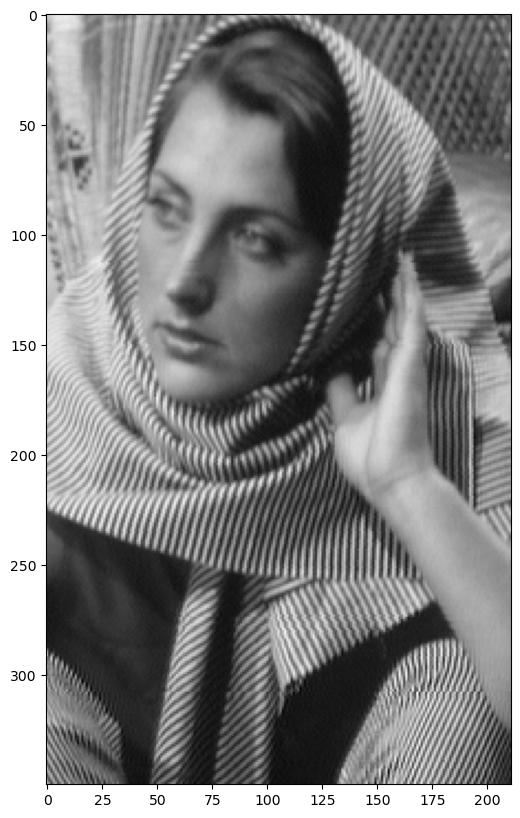

In [2]:
u = 255 * mpimg.imread("barbara.png")
u = u[0:350,300:511]    # image de taille moyenne
#u = u[100:140,300:331]   # Toute petite image pour debugger

plt.figure(figsize = (10,10))
plt.imshow(u,cmap='gray')
plt.show()

## Fonction calculant la quantification

In [3]:
def quantifie_image(u,tau):

    return tau * np.around(u/tau)

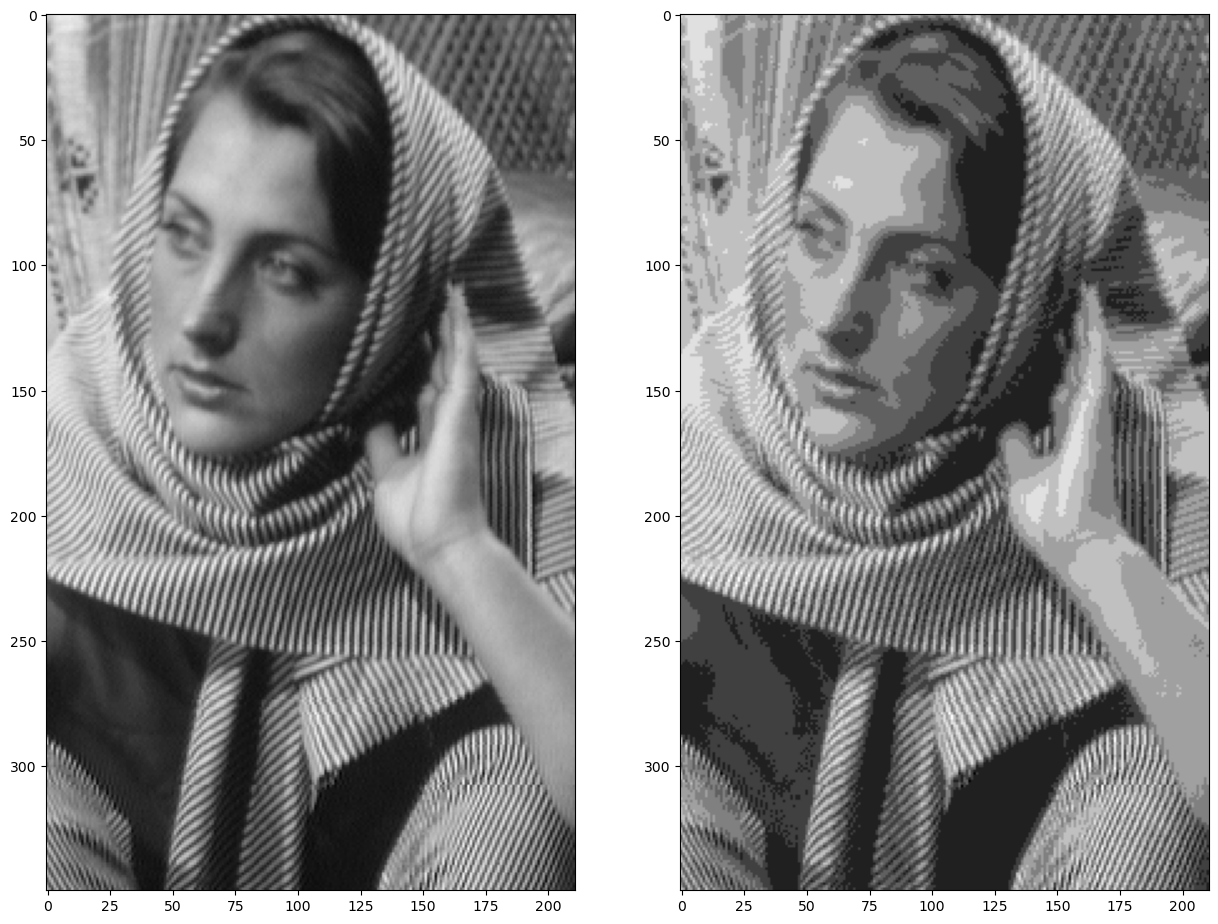

In [4]:
tau=30
v = quantifie_image(u,tau)

plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(u,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(v,cmap='gray')



## Fonction calculant itérativement le minimiseur

In [21]:
def grad_x(img, adjoint):
    sx , sy = np.shape(img)
    diff_x = np.copy(img)
    
    if adjoint==0:
        for x in range(sx):
            if x==sx-1:
                xnext=0
            else:
                xnext=x+1
            for y in range(sy):
                diff_x[x,y] = img[xnext,y]- img[x,y]
    else:
        for x in range(sx):
            if x==0:
                xprev=sx-1
            else:
                xprev=x-1
            for y in range(sy):
                diff_x[x,y] = img[xprev,y]- img[x,y]
    
    return diff_x

def verifie_grad_x(in1,in2):
    tmp1 = sum(sum(grad_x(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_x(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    return tmp1==tmp2
    
def grad_y(img, adjoint):
    sx , sy = np.shape(img)
    diff_y =  np.copy(img)

    if adjoint==0:
       
        for y in range(sy):
            if y==sy-1:
                ynext=0
            else:
                ynext=y+1
            for x in range(sx):
                diff_y[x,y] = img[x,ynext]- img[x,y]
    else:
        for y in range(sy):
            if y==0:
                yprev=sy-1
            else:
                yprev=y-1
            for x in range(sx):
                diff_y[x,y] = img[x,yprev]- img[x,y]
    
    return diff_y

def verifie_grad_y(in1,in2):
    tmp1 = sum(sum(grad_y(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_y(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
################################
def phi(img,tau):
    tmp = np.abs( np.copy(img))-tau/2
    
    return tmp * tmp * (tmp>0)

def phi_p(img,tau):
    dom = (np.abs(img)-tau/2 ) >0
    
    return (2*img - np.sign(img)*tau)*dom

def grad_E(out,v,tau,Lambda):
    tmpx = grad_x(out,0)
    tmpx1 = grad_x(tmpx,1)
    tmpy = grad_y(out,0)
    tmpy1 = grad_y(tmpy,1)
    
    grad = 2 * (tmpx1 + tmpy1) + Lambda * phi_p(out-v,tau)
    
    return grad

def E(out,v,tau,Lambda):
    sx , sy = np.shape(out)
    gx = np.linalg.norm( grad_x(out,0), ord='fro')
    gy = np.linalg.norm( grad_y(out,0), ord='fro')
    data = np.linalg.norm( phi(out - v,tau) , ord='fro')
    
    return (gx*gx + gy*gy + Lambda *data)/(sx*sy)

def deQuantifie(v,tau,Lambda,nbIter):
    pas = 1/(8+2*Lambda)
    v = quantifie_image(v,tau)

    out = np.copy(v)                # initialisation proche de la solution
#    out = np.zeros(np.shape(v))    # initialisation plus lointaine (pour tester)

    for it in range(nbIter):
        d = grad_E(out,v,tau,Lambda)
        out = out - pas * d
        #print( 'iter = ', it , 'fonction = ', E(out,v,tau,Lambda) ,\
             # 'max contrainte = ', (np.abs(out-v)-(tau/2)).max() ,\
             # 'H1 = ', E(out,v,tau,0) , \
             # 'norm grad =', np.linalg.norm(d) )
        
    return out

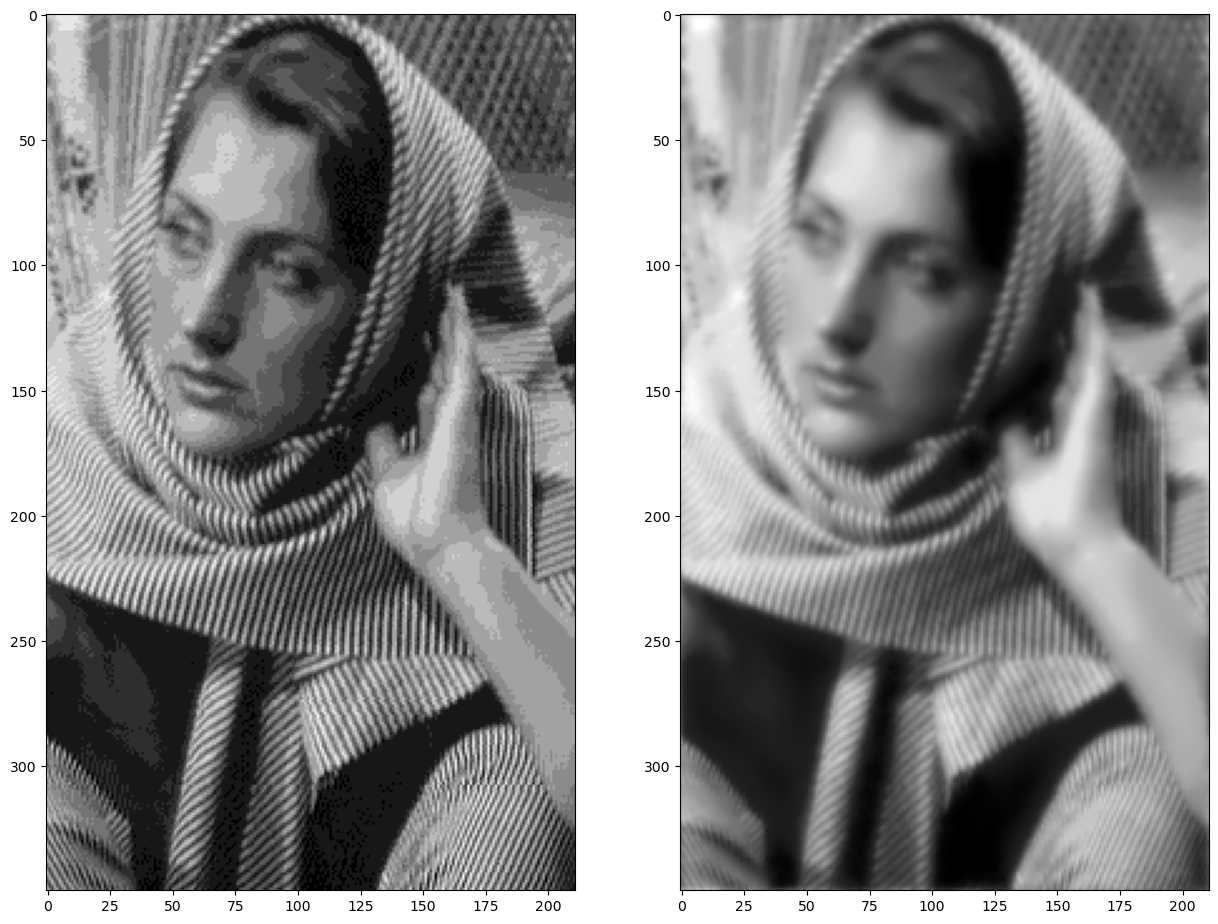

In [6]:
tau = 20
v = quantifie_image(u,tau)
Lambda=1
out = deQuantifie(v,tau,Lambda,100)


plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(v,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out,cmap='gray')

# Exercice 1

## Question 2 

## a)

$$
\phi^{'}_\tau(t) = \left\{
    \begin{array}{ll}
        -2(-t-\frac{\tau}{2}) & \mbox{si }t \leq - \tau/2 \\
        2(t-\frac{\tau}{2}) & \mbox{si } t \geq  \tau/2 \\
        0 & \mbox{sinon}
    \end{array}
\right.
$$

## b)

On a $\nabla E(w) = 2Bw$ avec $B = D^{*}_{x}D_{x} + D^{*}_{y}D_{y}$

on a donc : 
     $ \nabla F_\lambda(w) = 
        \nabla E(w)+ \lambda\sum_{i,j}^{N-1} \phi^{'}_\tau(w_{i,j} - v_{i,j})  
$ 

d où $$ \nabla F_\lambda(w) = \left\{
    \begin{array}{ll}
        2Bw + \lambda\sum_{i,j}^{N-1} -2((w_{i,j} - v_{i,j}) -\frac{\tau}{2}) & \mbox{si } w_{i,j} - v_{i,j} \leq -\frac{\tau}{2} \\
        2Bw + \lambda\sum_{i,j}^{N-1} 2((v_{i,j} - w_{i,j}) -\frac{\tau}{2}) & \mbox{si } w_{i,j} - v_{i,j} \geq \frac{\tau}{2}  \\
        2Bw & \mbox{sinon.}
    \end{array}
\right.$$ 

## c)

In [7]:
def deQuantifie(v,tau,Lambda,nbIter):
    pas = 1/(8+2*Lambda)  # pas constant (constante de lipschitz)
    v = quantifie_image(v,tau) # prend l'image quantifié de v

    out = np.copy(v)                # initialisation proche de la solution
#    out = np.zeros(np.shape(v))    # initialisation plus lointaine (pour tester)

    for it in range(nbIter):
        d = grad_E(out,v,tau,Lambda) # direction de descente avec grad_E correspond au gradient de la fonction F_lambda 
        out = out - pas * d   # Mise à jour de l'itéré
        print( 'iter = ', it , 'fonction = ', E(out,v,tau,Lambda) ,\
              'max contrainte = ', (np.abs(out-v)-(tau/2)).max() ,\
              'H1 = ', E(out,v,tau,0) , \
              'norm grad =', np.linalg.norm(d) )
        
    return out

On remarque que les fonctions sont approximativement les mêmes, la fonction deQuantifie reprends notre algorithme de gradient à pas constant avec un image tout d'abord quantifier et un pas très précis. 

On prend le pas faisant converger l'algorithme donc un pas plus petit que $  \frac{1}{L}  $ avec L la constante de Lispschitz

Ici on prends donc $ \frac{1}{2*\lambda +8} $ 

# exo 3)

Lambda:  0.01
iter =  99

Différence entre la fonction F de notre deuxième itération et de notre première :  118.9035965650389
Différence entre la fonction F de notre avant-dernière itération et de notre dernière :  0.0631881389641169
Différence entre la fonction F de notre première itération et de notre dernière :  230.29201809305178

Gradient de la première itération =  33670.45 Gradient de la dernière itération =  669.7667
Différence entre le gradient de d à la première itération et de notre dernière :  33000.684


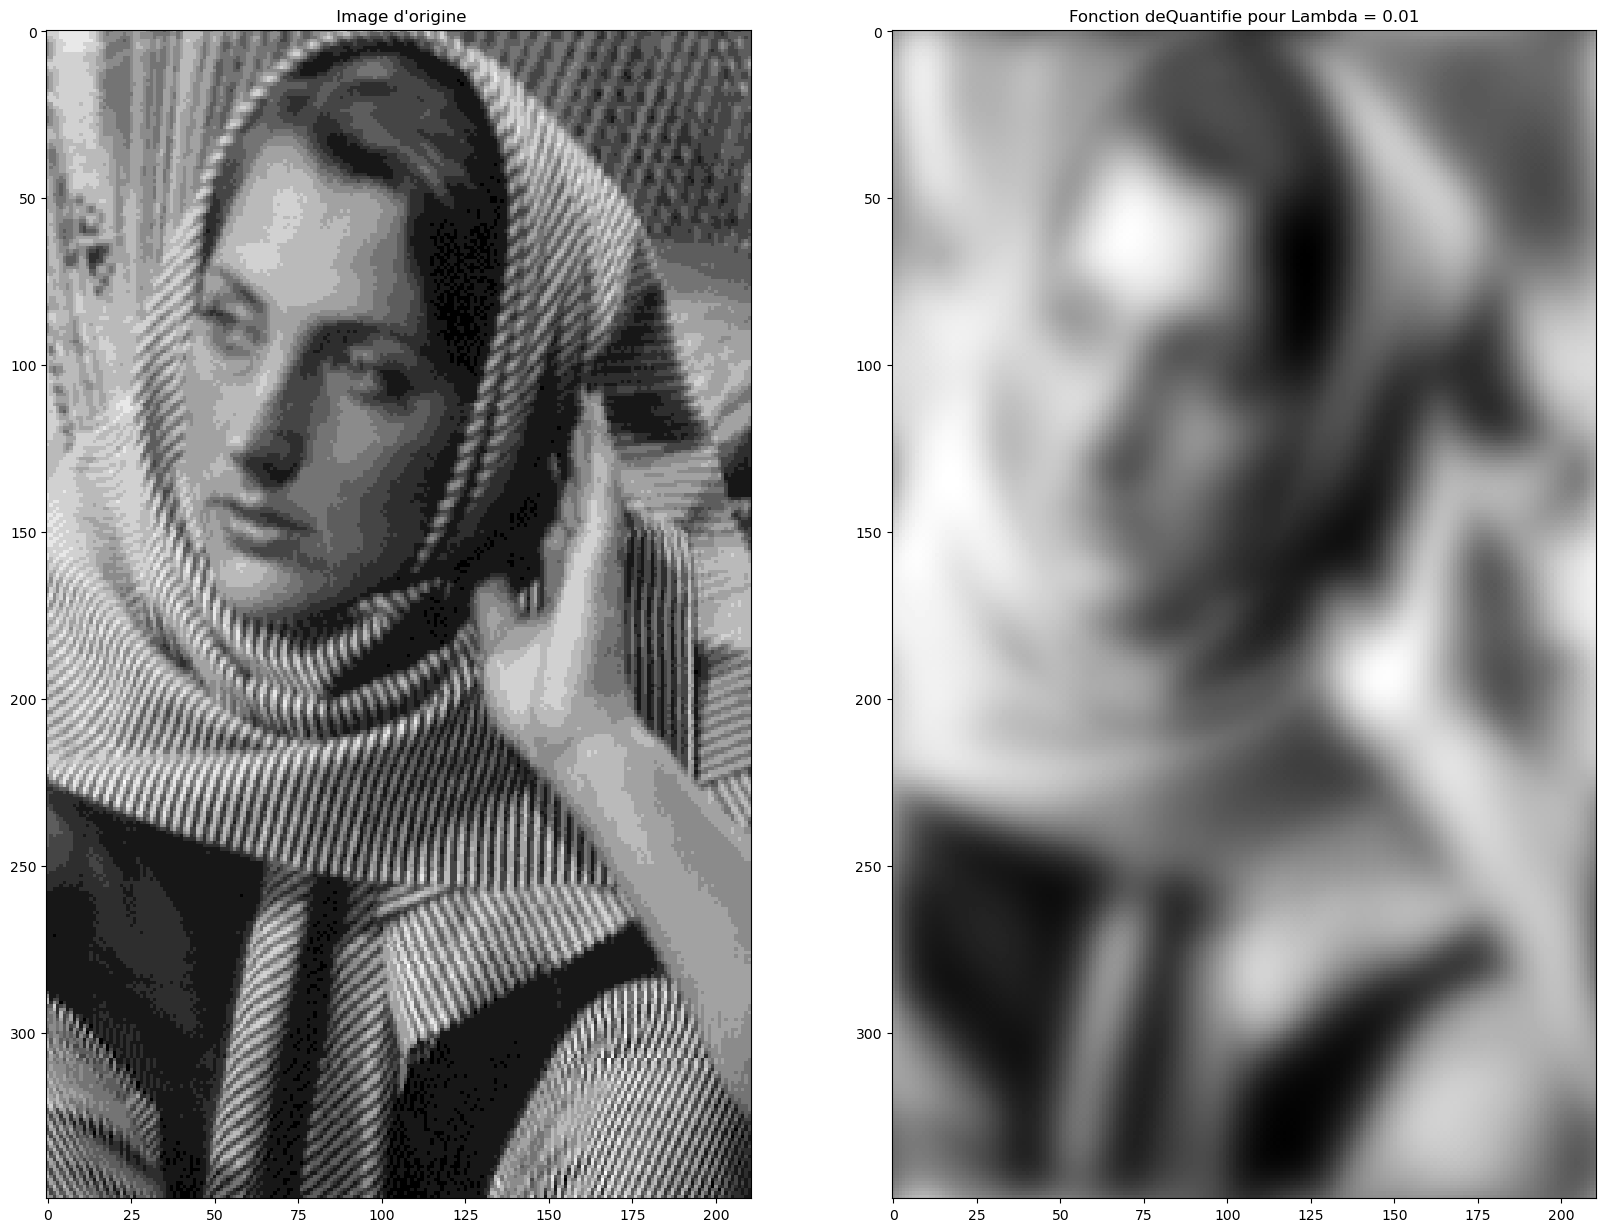

Lambda:  0.1
iter =  99

Différence entre la fonction F de notre deuxième itération et de notre première :  119.84098269295868
Différence entre la fonction F de notre avant-dernière itération et de notre dernière :  0.022957811442115172
Différence entre la fonction F de notre première itération et de notre dernière :  224.9479346648612

Gradient de la première itération =  33670.45 Gradient de la dernière itération =  67.63576
Différence entre le gradient de d à la première itération et de notre dernière :  33602.812


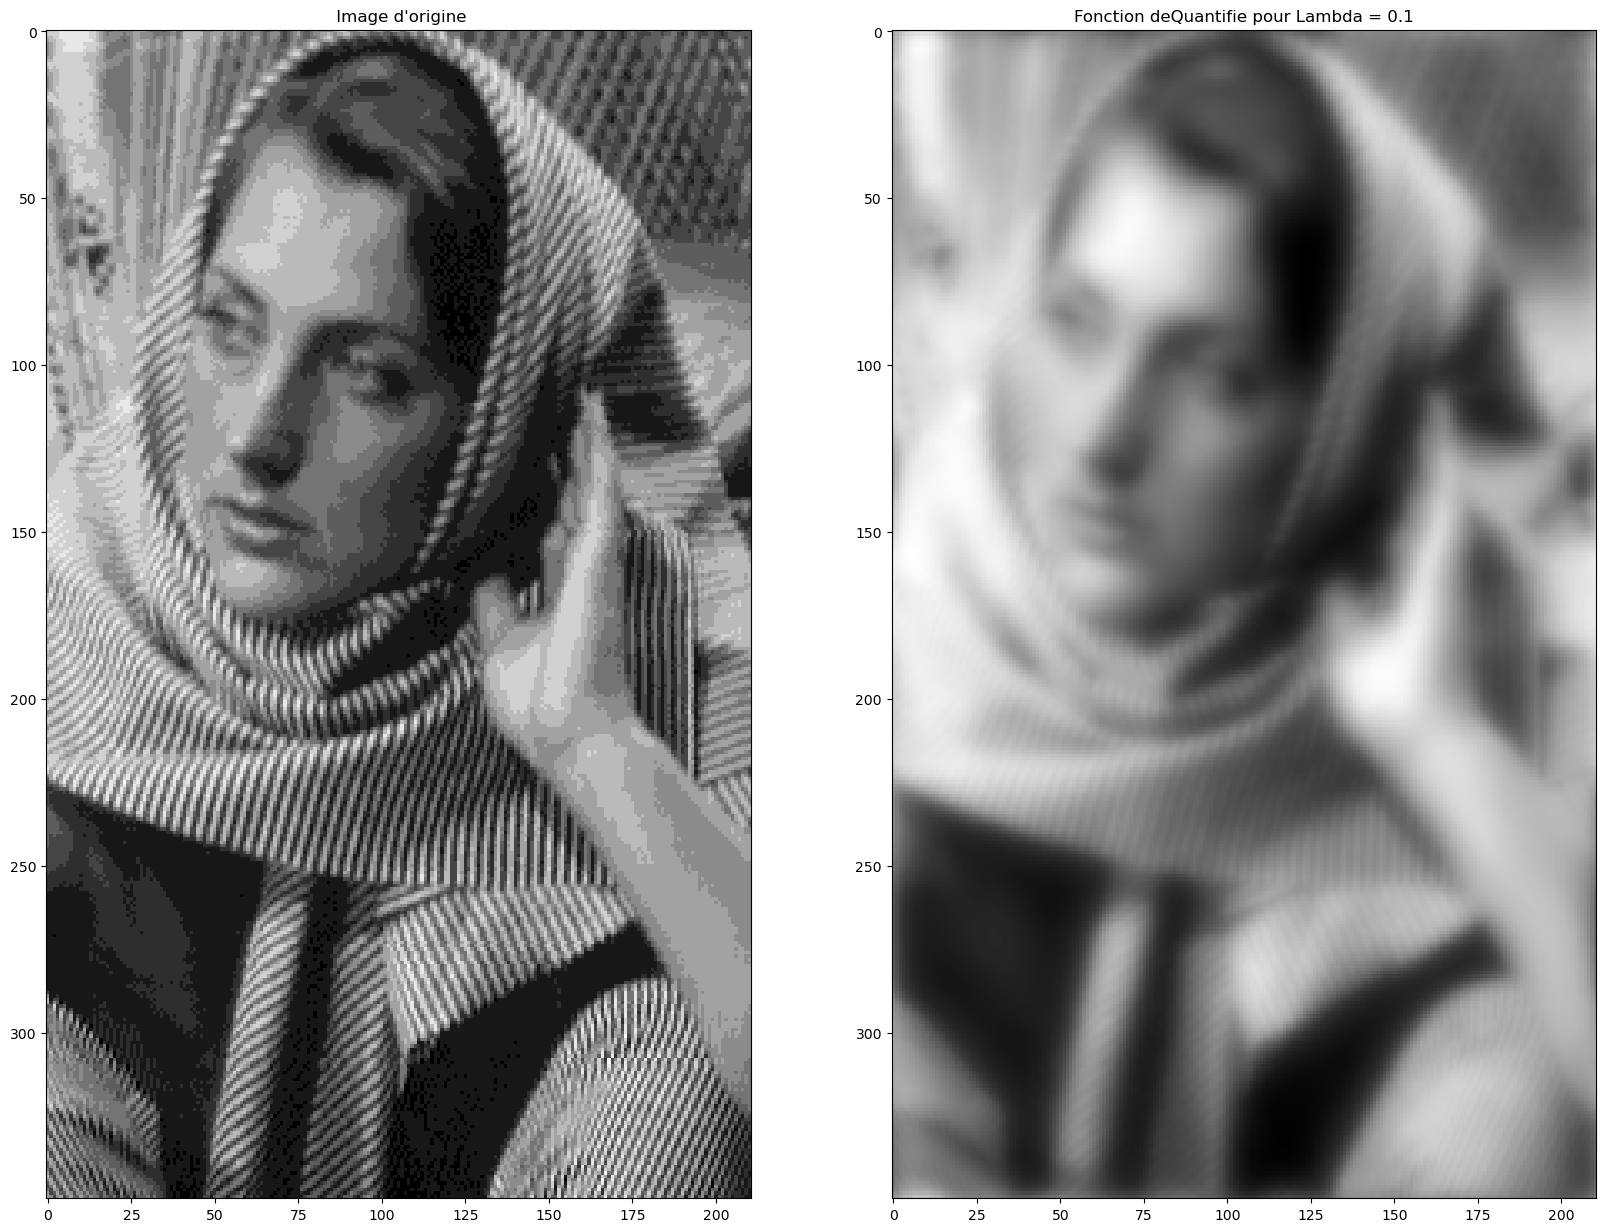

Lambda:  1
iter =  99

Différence entre la fonction F de notre deuxième itération et de notre première :  130.5885777230027
Différence entre la fonction F de notre avant-dernière itération et de notre dernière :  0.0013807549085953497
Différence entre la fonction F de notre première itération et de notre dernière :  209.07265989971222

Gradient de la première itération =  33670.45 Gradient de la dernière itération =  23.224453
Différence entre le gradient de d à la première itération et de notre dernière :  33647.227


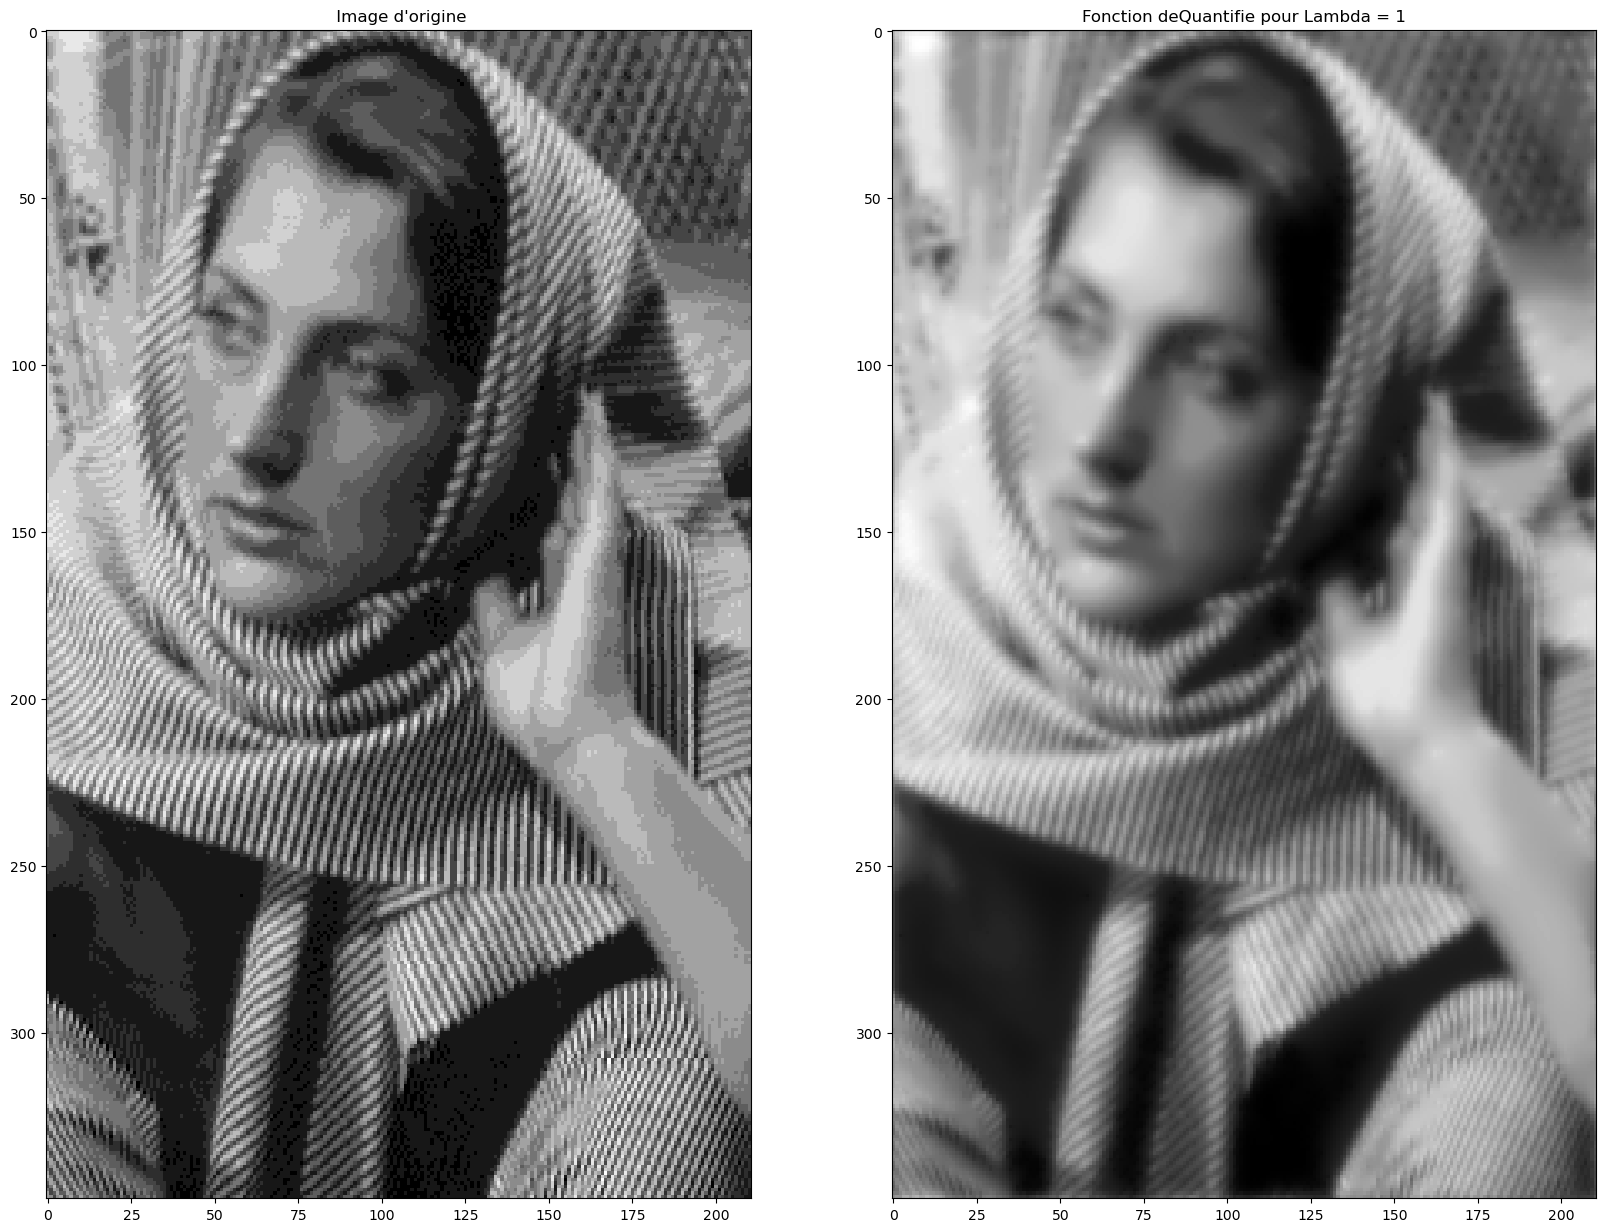

Lambda:  10
iter =  99

Différence entre la fonction F de notre deuxième itération et de notre première :  239.19865761996437
Différence entre la fonction F de notre avant-dernière itération et de notre dernière :  0.002707927809751709
Différence entre la fonction F de notre première itération et de notre dernière :  359.5165274045785

Gradient de la première itération =  33670.45 Gradient de la dernière itération =  71.54147
Différence entre le gradient de d à la première itération et de notre dernière :  33598.906


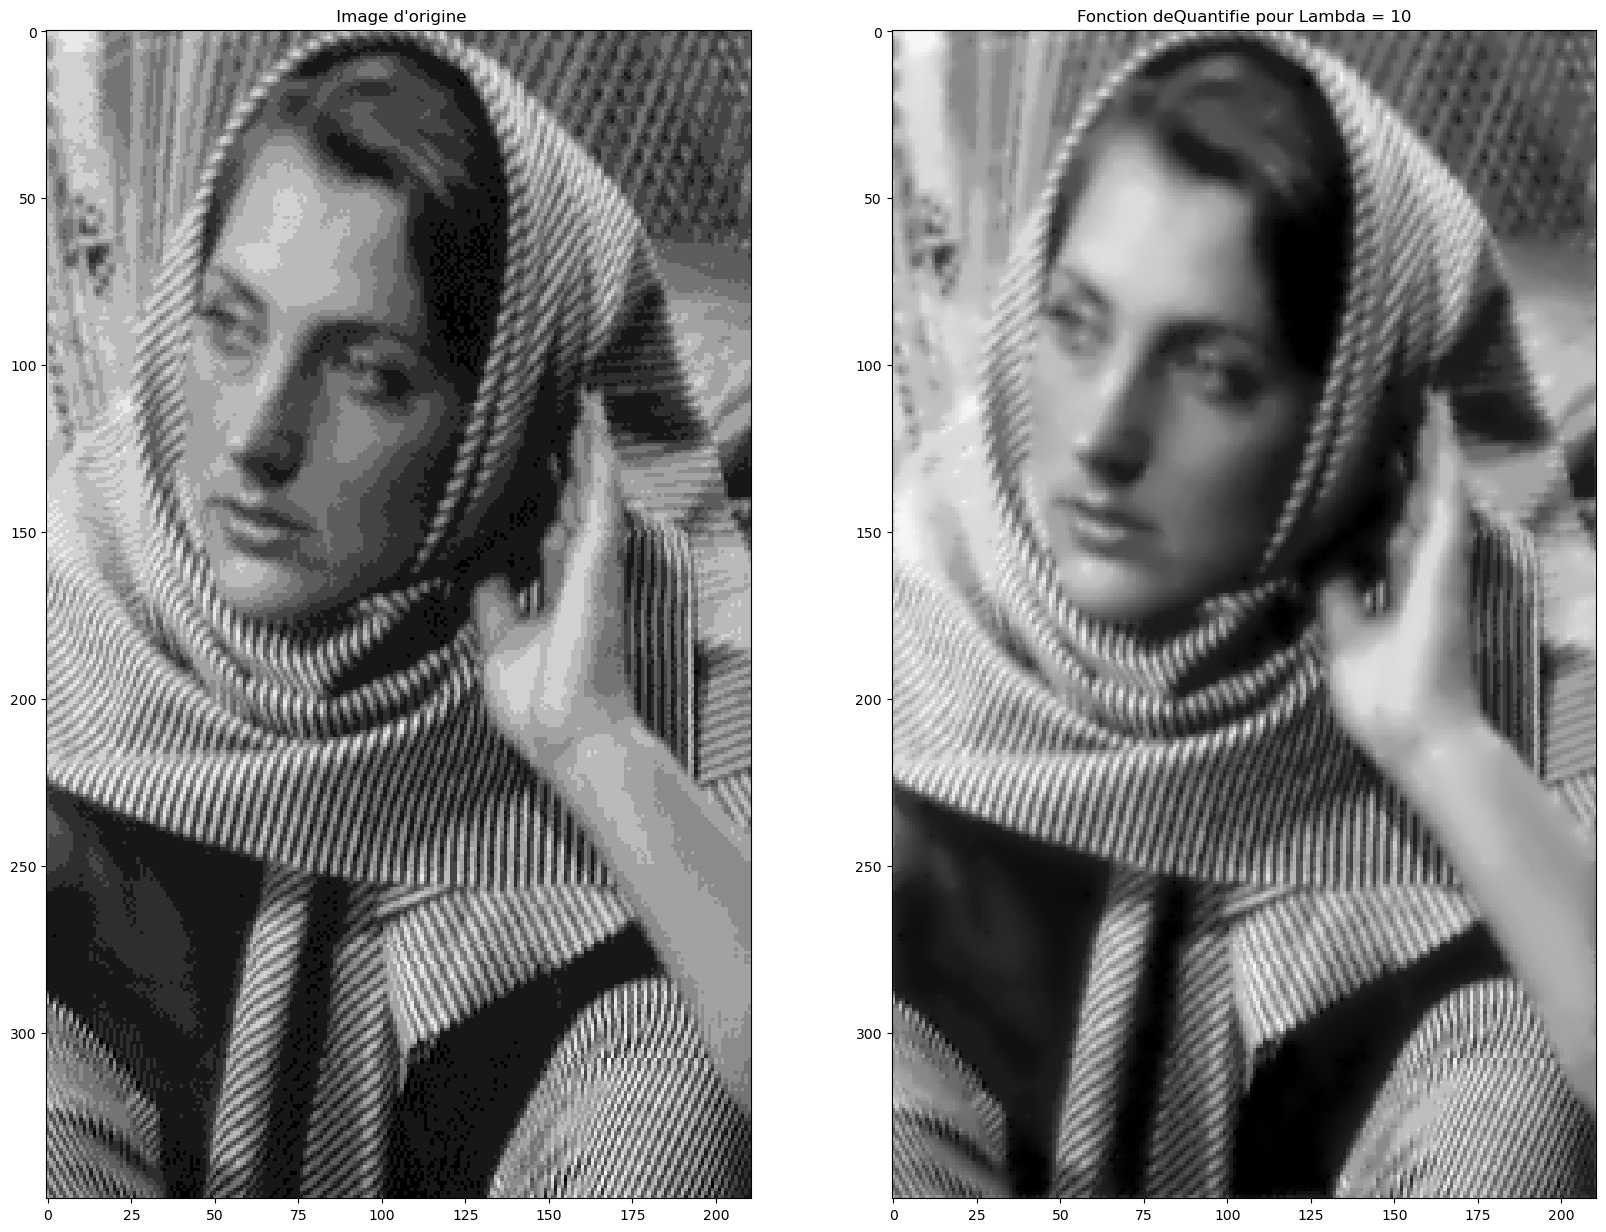

In [22]:
# On change juste l'affichage de la fonction deQuantifie

def deQuantifie1(v,tau,Lambda,nbIter):
    pas = 1/(8+2*Lambda)
    v = quantifie_image(v,tau)
    fonction=[]
    norm_grad=[]
    out = np.copy(v)                # initialisation proche de la solution
    for it in range(nbIter):
        d = grad_E(out,v,tau,Lambda)
        out = out - pas * d
        fonction.append(E(out,v,tau,Lambda))
        norm_grad.append(np.linalg.norm(d))
        
    d = grad_E(out,v,tau,Lambda)
    out = out - pas * d    
    fonction.append(E(out,v,tau,Lambda))
    #On change l'affichage pour montrer la convergence 
    print( 'iter = ', it)
    print("")
    print('Différence entre la fonction F de notre deuxième itération et de notre première : ', fonction[0]-fonction[1])
    print('Différence entre la fonction F de notre avant-dernière itération et de notre dernière : ', fonction[-2]-fonction[-1])
    print('Différence entre la fonction F de notre première itération et de notre dernière : ', fonction[0]-fonction[-1])
    print("")
    print('Gradient de la première itération = ', norm_grad[0], 'Gradient de la dernière itération = ', norm_grad[-1])
    print('Différence entre le gradient de d à la première itération et de notre dernière : ', norm_grad[0]-norm_grad[-1] )    
    return out



tau = 20
v = quantifie_image(u,tau)
Lambda=[0.01,0.1,1,10]

for lbd in Lambda:
    print("Lambda: ",lbd)
    out = deQuantifie1(v,tau,lbd,100)

    plt.figure(figsize = (20,20))
    plt.subplot(1,2,1)
    plt.title(" Image d'origine")
    plt.imshow(v,cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Fonction deQuantifie pour Lambda = "+str(lbd))
    plt.imshow(out,cmap='gray')
    plt.show()

On voit, bien évidemment, que plus le $ \lambda $ augmente plus les images sont prôche de l'image de base

Pour voir si l'algorithme converge nous voulons regarder si la fonction s'approche de son minimum c'est à dire lorsque les valeurs de $ F(x_{k}) $ se rapprochent et que le grad est très proche de 0.

On remarque déjà, d'après la différence entre les valeurs de la dernière itération et de la première itération, que peu importe le lambda la fonction décroît et le gradient aussi.

la fonction F s'approche donc bien de son minimum, mais pour 100 itérations le gradient est encore assez loin de 0. Testons pour plus d'itérations:

Lambda:  0.01
iter =  199

Différence entre la fonction F de notre deuxième itération et de notre première :  118.9035965650389
Différence entre la fonction F de notre avant-dernière itération et de notre dernière :  0.017624873053486922
Différence entre la fonction F de notre première itération et de notre dernière :  233.52006065821766

Gradient de la première itération =  33670.45 Gradient de la dernière itération =  342.15915
Différence entre le gradient de d à la première itération et de notre dernière :  33328.29


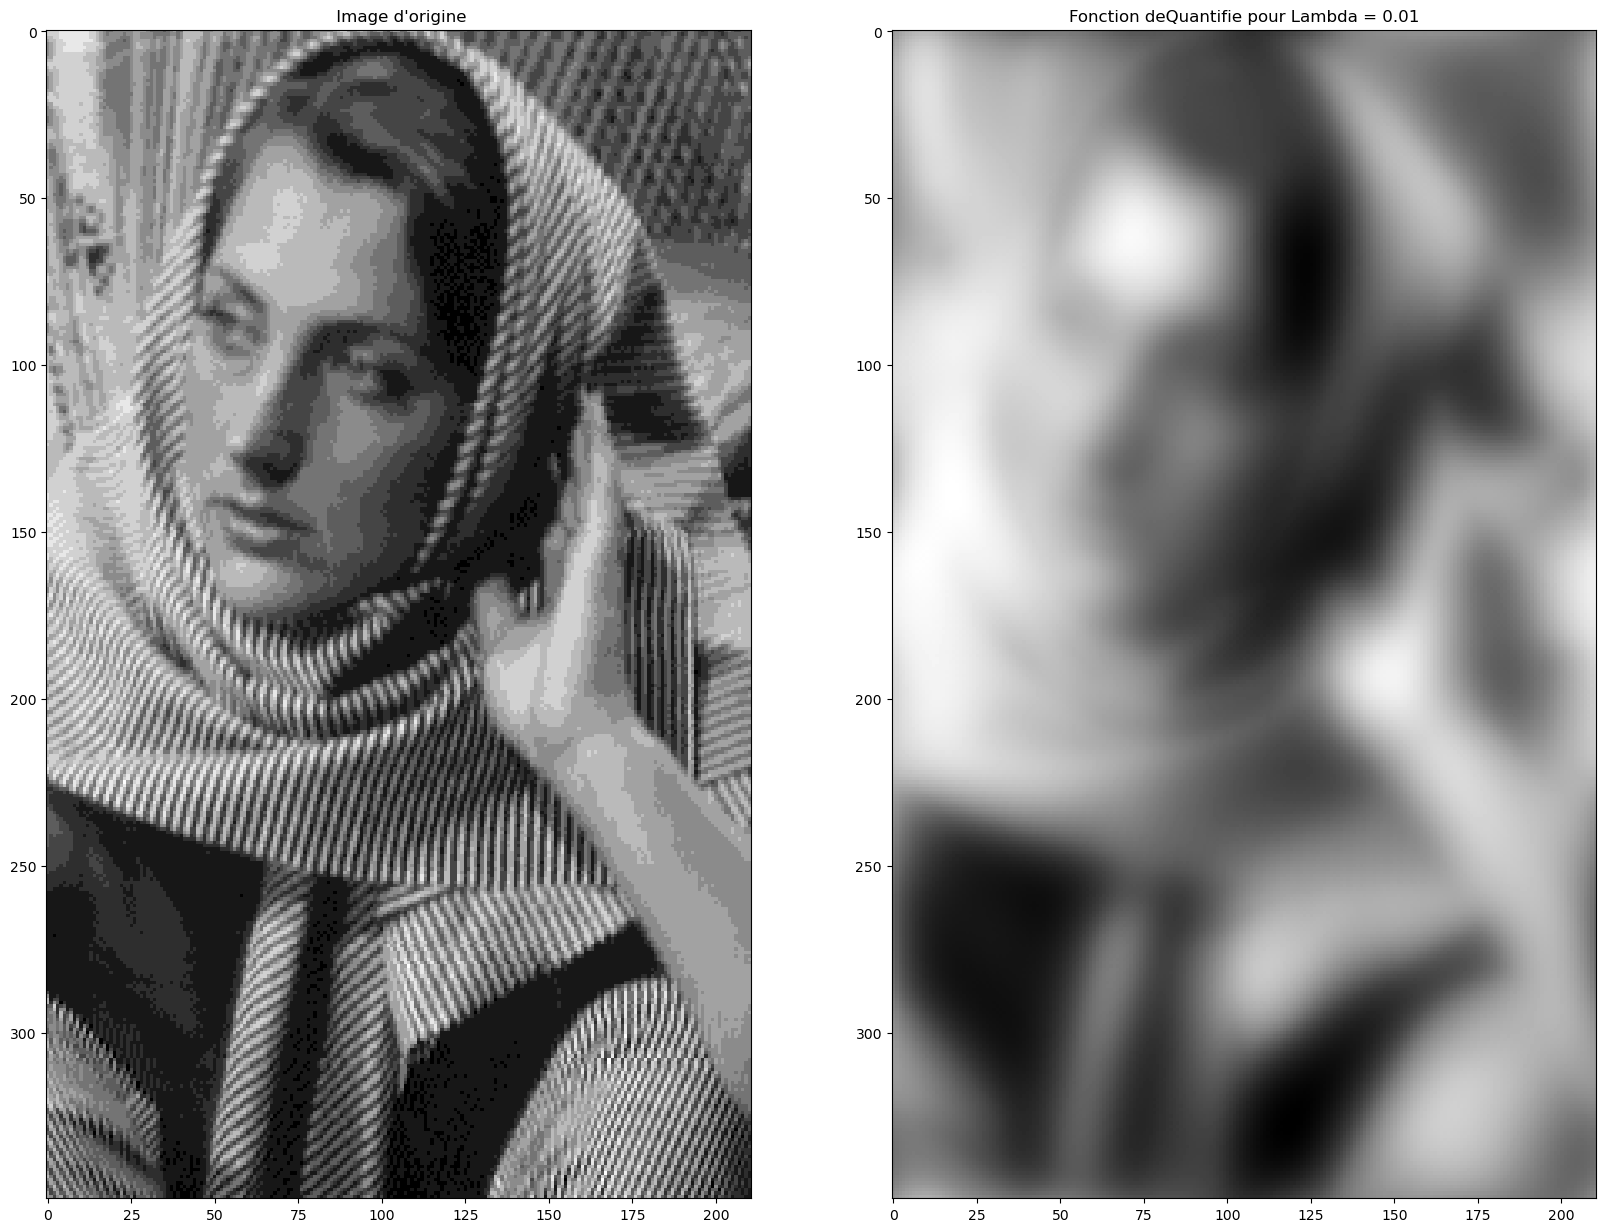

Lambda:  0.1
iter =  199

Différence entre la fonction F de notre deuxième itération et de notre première :  119.84098269295868
Différence entre la fonction F de notre avant-dernière itération et de notre dernière :  0.0020065589031812436
Différence entre la fonction F de notre première itération et de notre dernière :  225.71441663845633

Gradient de la première itération =  33670.45 Gradient de la dernière itération =  12.027689
Différence entre le gradient de d à la première itération et de notre dernière :  33658.42


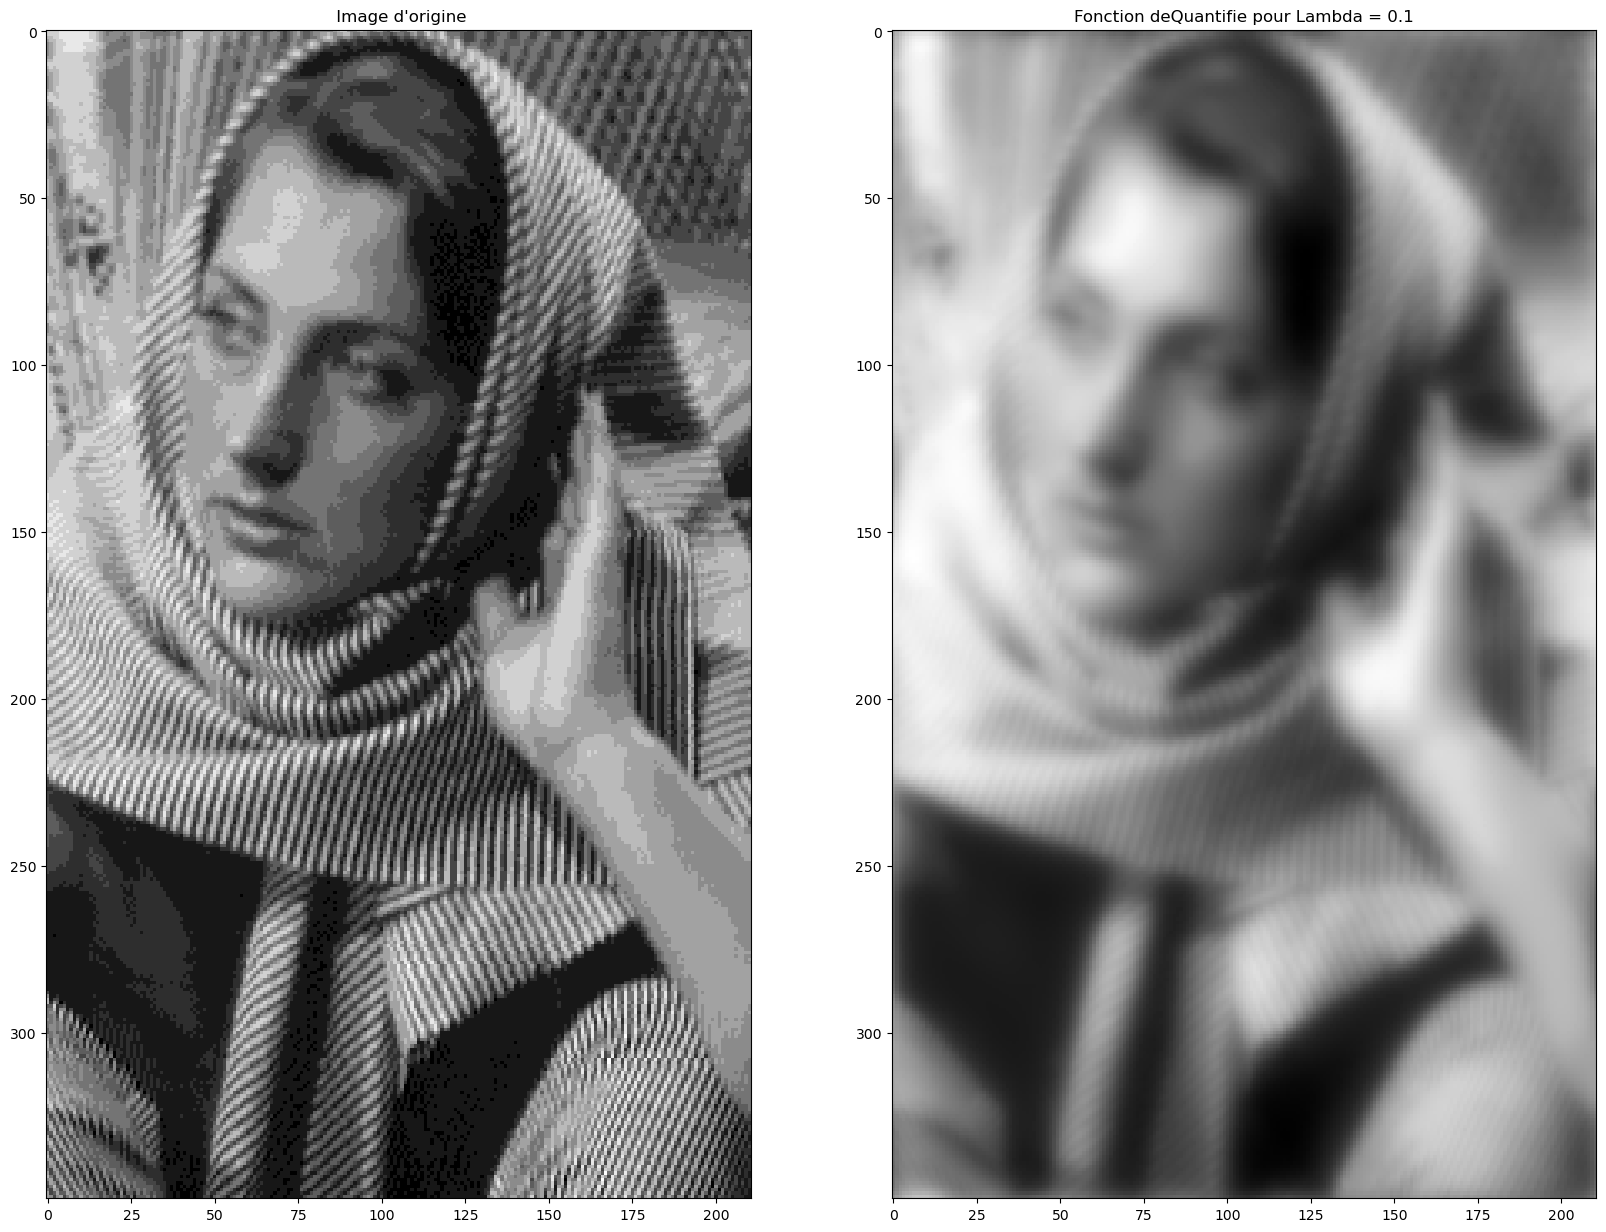

Lambda:  1
iter =  199

Différence entre la fonction F de notre deuxième itération et de notre première :  130.5885777230027
Différence entre la fonction F de notre avant-dernière itération et de notre dernière :  0.0001218686526840429
Différence entre la fonction F de notre première itération et de notre dernière :  209.11946677175015

Gradient de la première itération =  33670.45 Gradient de la dernière itération =  7.538765
Différence entre le gradient de d à la première itération et de notre dernière :  33662.91


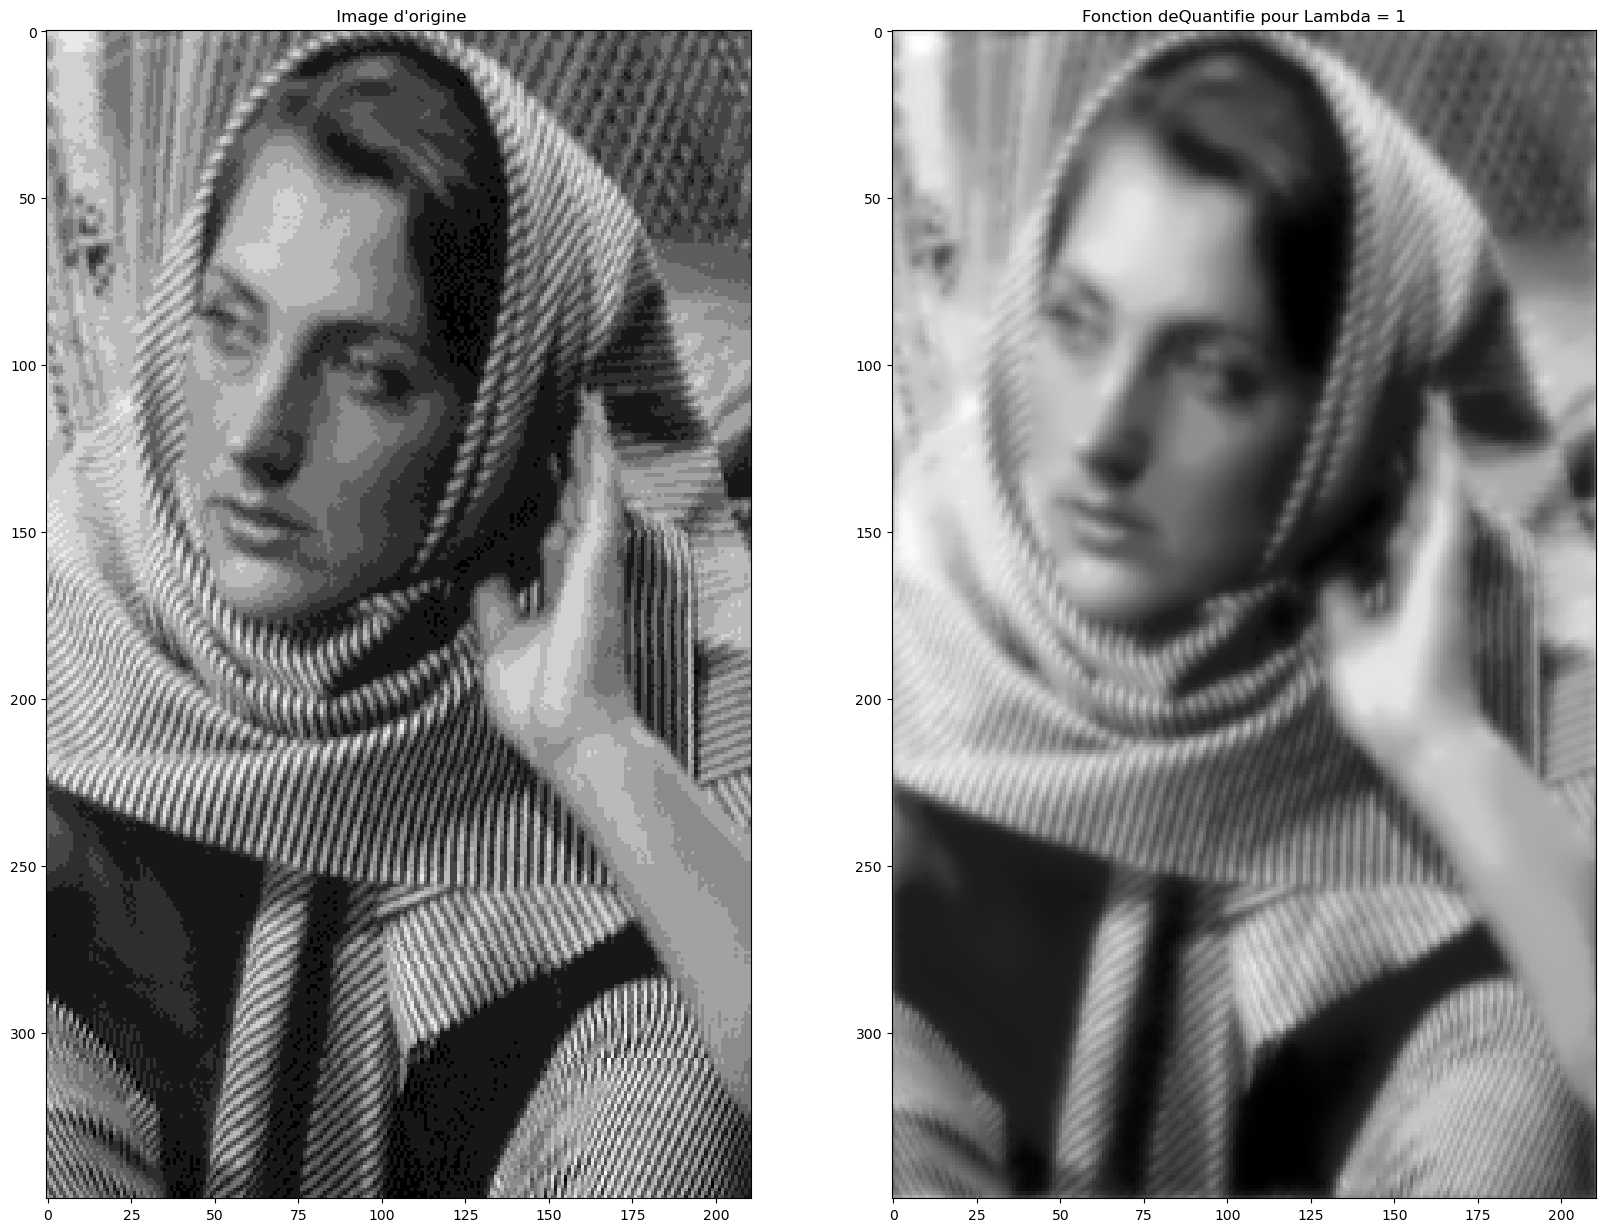

Lambda:  10
iter =  199

Différence entre la fonction F de notre deuxième itération et de notre première :  239.19865761996437
Différence entre la fonction F de notre avant-dernière itération et de notre dernière :  0.0005685881432100359
Différence entre la fonction F de notre première itération et de notre dernière :  359.6368357259224

Gradient de la première itération =  33670.45 Gradient de la dernière itération =  30.76192
Différence entre le gradient de d à la première itération et de notre dernière :  33639.688


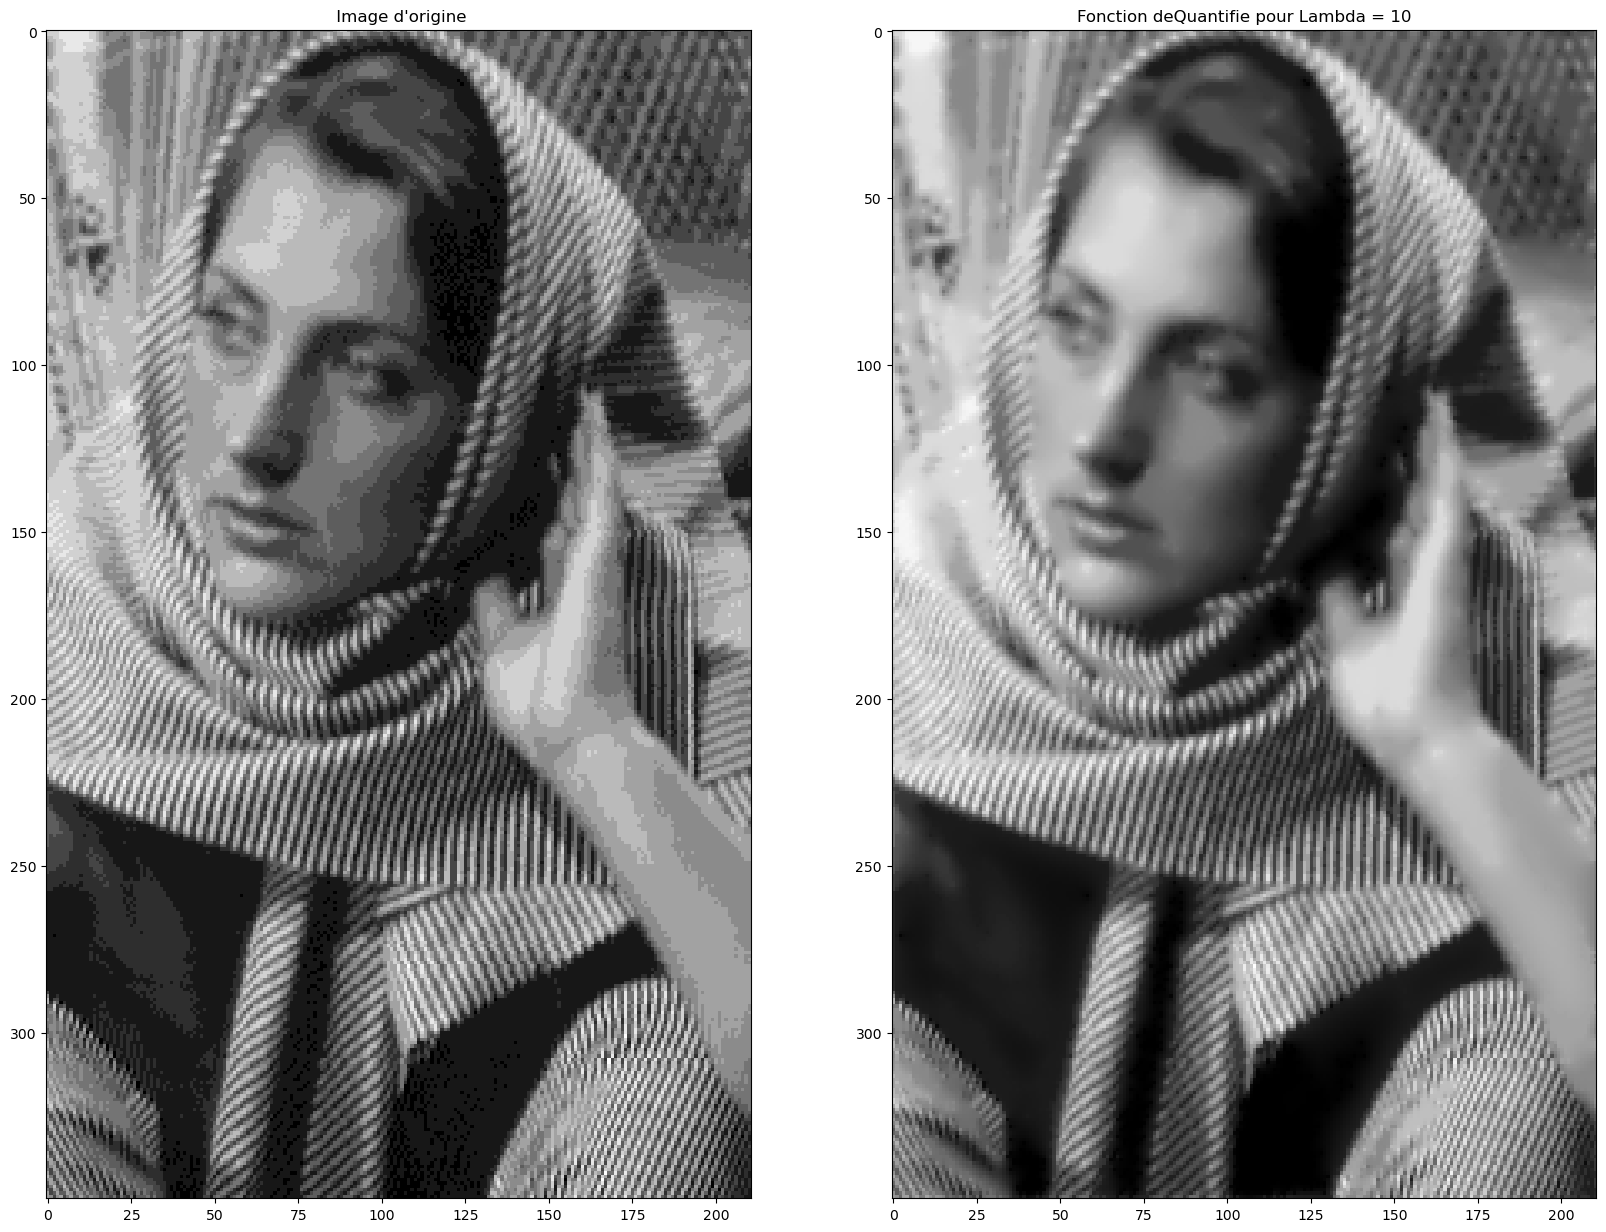

In [18]:
#Pour 200 itérations
tau = 20
v = quantifie_image(u,tau)
Lambda=[0.01,0.1,1,10]

for lbd in Lambda:
    print("Lambda: ",lbd)
    out = deQuantifie(v,tau,lbd,200)

    plt.figure(figsize = (20,20))
    plt.subplot(1,2,1)
    plt.title(" Image d'origine")
    plt.imshow(v,cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Fonction deQuantifie pour Lambda = "+str(lbd))
    plt.imshow(out,cmap='gray')
    plt.show()

Lorsque nous faisons 200 itérations le gradient est très prôche de 0 et la différence de valeurs entre les fonctions est prôche de 0 aussi ).Ceci étant dit il n'y pas de différence visuel visible à l'oeil nu entre les images

# Exercice 2

## Question 1


$$
\prod(w) = \left\{
    \begin{array}{ll}
        v_{i,j}+\frac{\tau}{2} & \mbox{si}&  w_{i,j} > v_{i,j}+\frac{\tau}{2} \\
        v_{i,j}-\frac{\tau}{2} & \mbox{si}&  w_{i,j} < v_{i,j}-\frac{\tau}{2} \\
        w_{i,j} & \mbox{sinon}
    \end{array}
\right.
$$

## Question 2)

In [ ]:
#Nous refaisons une fonction grad(E) car dans cet exercice ce n'est pas le même gradient de E ( nous n'avons plus le lambda et les phi)
def grad_E1(out):
    tmpx = grad_x(out,0)
    tmpx1 = grad_x(tmpx,1)
    tmpy = grad_y(out,0)
    tmpy1 = grad_y(tmpy,1)
    
    return 2 * (tmpx1 + tmpy1) 


def projecteur(proj,v,tau):
    a=np.where(proj>v+tau/2,v+tau/2,proj) # si proj>v+tau/2, on remplace proj par sur+tau/2
    return  np.where(a<v-tau/2,v-tau/2,a) # si proj<v-tau/2, on remplace proj par sur-tau/2

def grad_proj(v,tau,nbIter,step):
    out=v
    for it in range (nbIter):
        d=grad_E1(out)
        out=projecteur(out-d*step,v,tau)
        #print( 'iter = ', it  ,\
                  #'max contrainte = ', (np.abs(out-v)-(tau/2)).max() ,\
                 # 'H1 = ', E(out,v,tau,0) , \
                 # 'norm grad =', np.linalg.norm(d) )
    return out

## test

Nombre d'itération: 1 

iter =  0 max contrainte =  0.0 H1 =  711.639864590386 norm grad = 33670.45
iter =  1 max contrainte =  0.0 H1 =  1043.8591740013542 norm grad = 24521.287
iter =  2 max contrainte =  0.0 H1 =  910.0121868652674 norm grad = 34808.043
iter =  3 max contrainte =  0.0 H1 =  1158.2992552471226 norm grad = 30561.021
iter =  4 max contrainte =  0.0 H1 =  968.013432633717 norm grad = 38025.137
iter =  5 max contrainte =  0.0 H1 =  1187.0223425863237 norm grad = 32423.56
iter =  6 max contrainte =  0.0 H1 =  986.5916316858497 norm grad = 38840.492
iter =  7 max contrainte =  0.0 H1 =  1197.6547054840894 norm grad = 33014.6
iter =  8 max contrainte =  0.0 H1 =  993.1184834123222 norm grad = 39136.02
iter =  9 max contrainte =  0.0 H1 =  1201.1184834123223 norm grad = 33223.57
iter =  10 max contrainte =  0.0 H1 =  995.4907515233582 norm grad = 39233.832
iter =  11 max contrainte =  0.0 H1 =  1202.1448882870684 norm grad = 33297.305
iter =  12 max contrainte =  0.0 H1 =  9

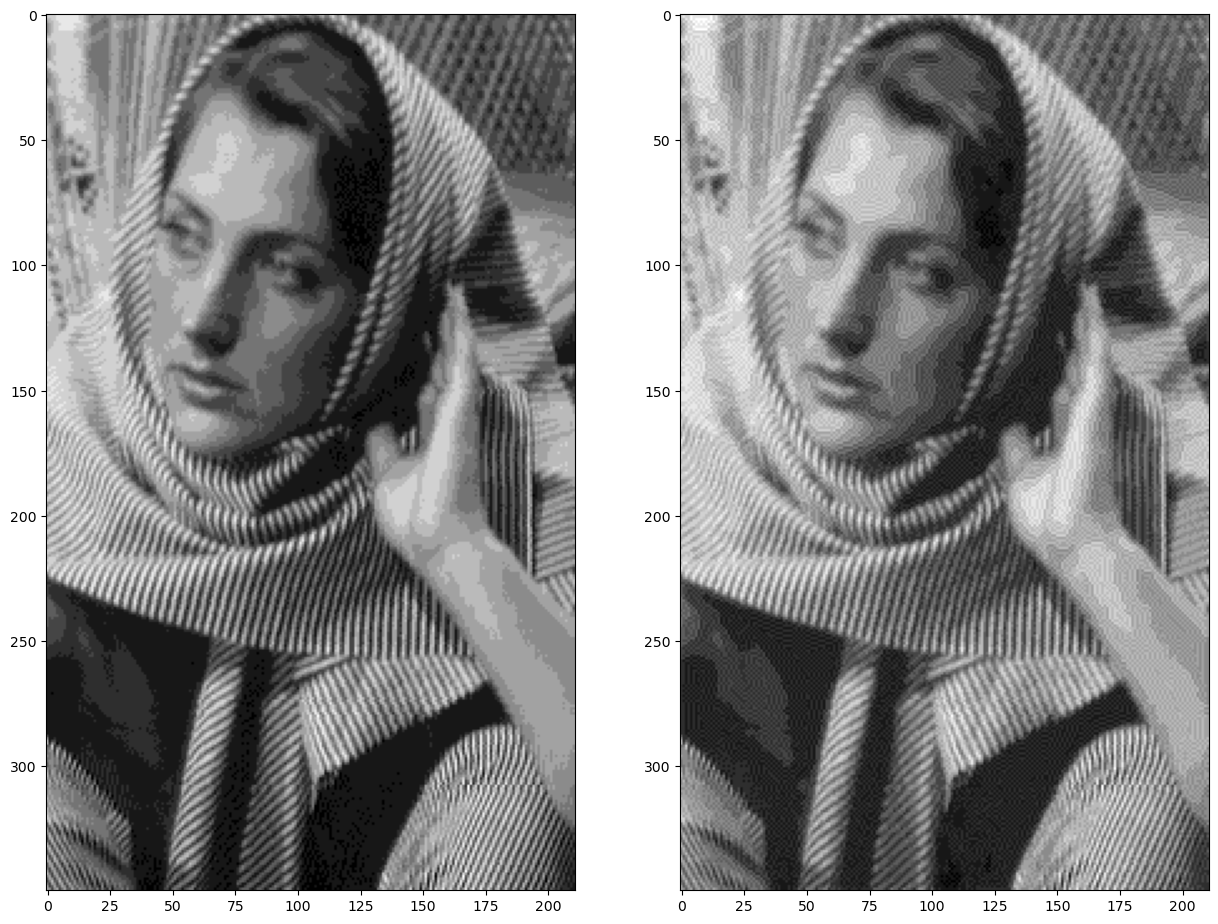

Nombre d'itération: 5 

iter =  0 max contrainte =  0.0 H1 =  711.639864590386 norm grad = 33670.45
iter =  1 max contrainte =  0.0 H1 =  1043.8591740013542 norm grad = 24521.287
iter =  2 max contrainte =  0.0 H1 =  910.0121868652674 norm grad = 34808.043
iter =  3 max contrainte =  0.0 H1 =  1158.2992552471226 norm grad = 30561.021
iter =  4 max contrainte =  0.0 H1 =  968.013432633717 norm grad = 38025.137
iter =  5 max contrainte =  0.0 H1 =  1187.0223425863237 norm grad = 32423.56
iter =  6 max contrainte =  0.0 H1 =  986.5916316858497 norm grad = 38840.492
iter =  7 max contrainte =  0.0 H1 =  1197.6547054840894 norm grad = 33014.6
iter =  8 max contrainte =  0.0 H1 =  993.1184834123222 norm grad = 39136.02
iter =  9 max contrainte =  0.0 H1 =  1201.1184834123223 norm grad = 33223.57
iter =  10 max contrainte =  0.0 H1 =  995.4907515233582 norm grad = 39233.832
iter =  11 max contrainte =  0.0 H1 =  1202.1448882870684 norm grad = 33297.305
iter =  12 max contrainte =  0.0 H1 =  9

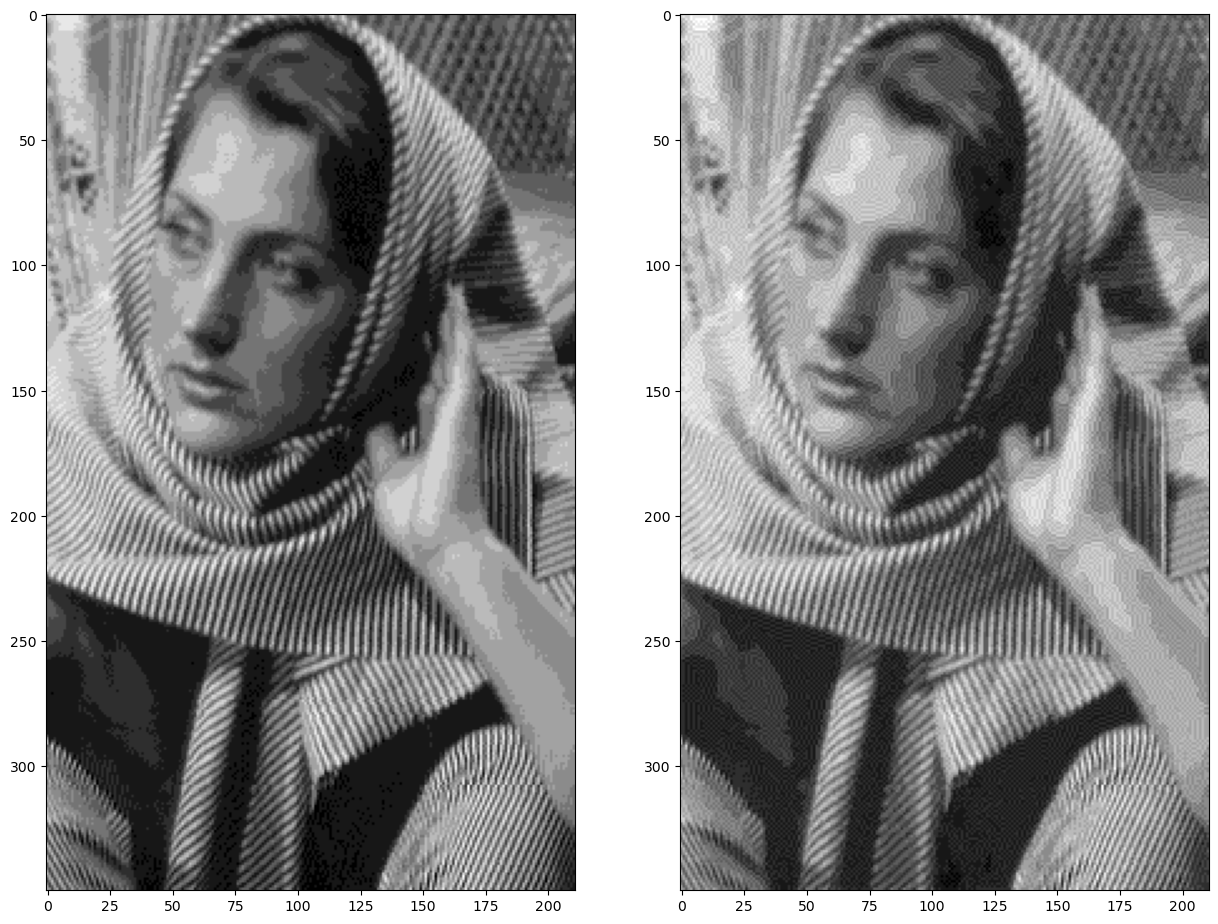

Nombre d'itération: 10 

iter =  0 max contrainte =  0.0 H1 =  711.639864590386 norm grad = 33670.45
iter =  1 max contrainte =  0.0 H1 =  1043.8591740013542 norm grad = 24521.287
iter =  2 max contrainte =  0.0 H1 =  910.0121868652674 norm grad = 34808.043
iter =  3 max contrainte =  0.0 H1 =  1158.2992552471226 norm grad = 30561.021
iter =  4 max contrainte =  0.0 H1 =  968.013432633717 norm grad = 38025.137
iter =  5 max contrainte =  0.0 H1 =  1187.0223425863237 norm grad = 32423.56
iter =  6 max contrainte =  0.0 H1 =  986.5916316858497 norm grad = 38840.492
iter =  7 max contrainte =  0.0 H1 =  1197.6547054840894 norm grad = 33014.6
iter =  8 max contrainte =  0.0 H1 =  993.1184834123222 norm grad = 39136.02
iter =  9 max contrainte =  0.0 H1 =  1201.1184834123223 norm grad = 33223.57
iter =  10 max contrainte =  0.0 H1 =  995.4907515233582 norm grad = 39233.832
iter =  11 max contrainte =  0.0 H1 =  1202.1448882870684 norm grad = 33297.305
iter =  12 max contrainte =  0.0 H1 =  

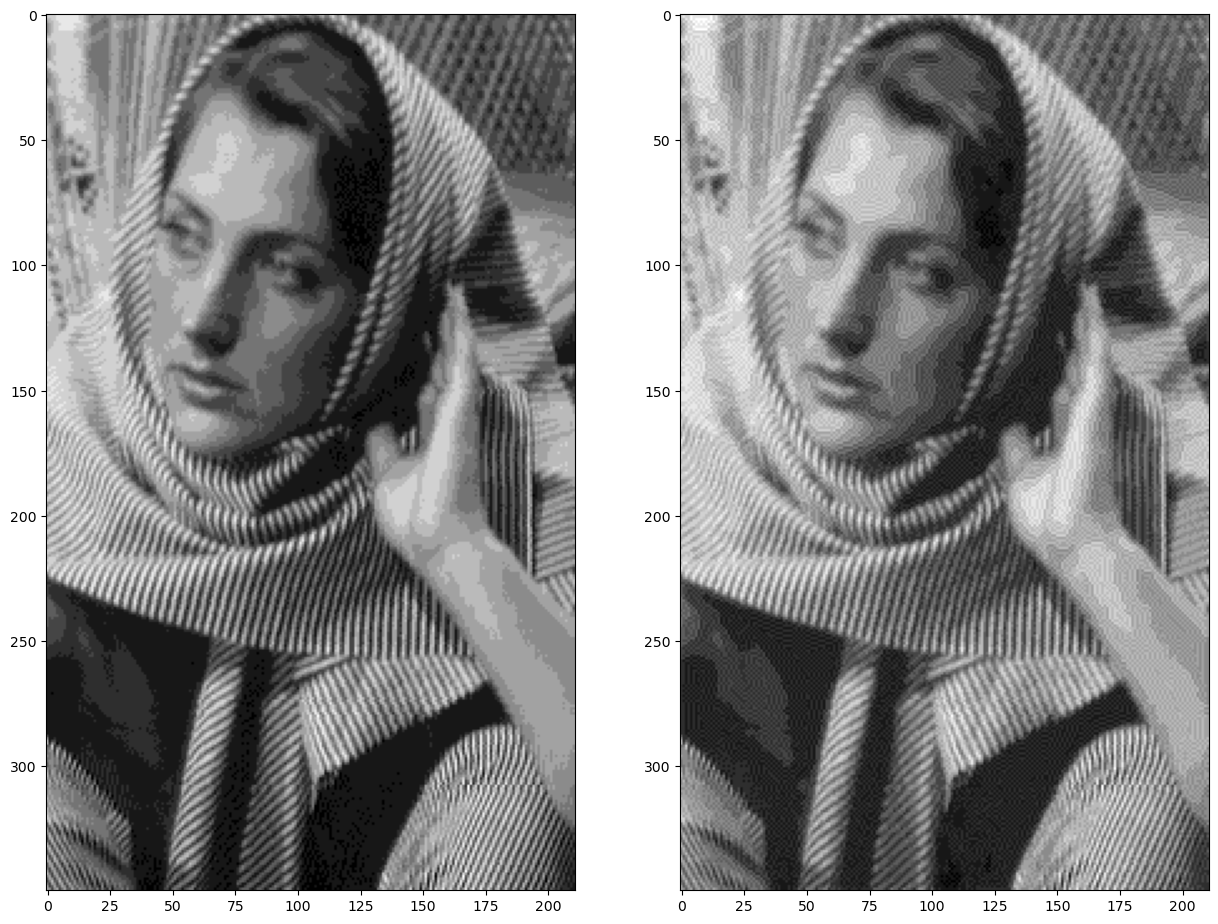

In [13]:
tau = 20
v = quantifie_image(u,tau)
iter=100
Err = []
for i in [1,5,10] :
    print("Nombre d'itération:",i,"\n")
    out = grad_proj(v,tau,iter,i)
    plt.figure(figsize = (20,0))
    plt.subplot(1,2,1)
    plt.imshow(v,cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out,cmap='gray')
    plt.show()

# Question 3



Lambda:  0.01
iter =  0 max contrainte =  0.0 H1 =  691.5712931618145 norm grad = 33670.45
iter =  1 max contrainte =  0.0 H1 =  675.2287610020311 norm grad = 23676.3
iter =  2 max contrainte =  0.0 H1 =  670.9988896411645 norm grad = 23656.54
iter =  3 max contrainte =  0.0 H1 =  669.2804874746107 norm grad = 23519.629
iter =  4 max contrainte =  0.0 H1 =  668.3669058903182 norm grad = 23538.475
iter =  5 max contrainte =  0.0 H1 =  667.8440622884225 norm grad = 23510.158
iter =  6 max contrainte =  0.0 H1 =  667.4991469194313 norm grad = 23518.717
iter =  7 max contrainte =  0.0 H1 =  667.2679756262695 norm grad = 23509.215
iter =  8 max contrainte =  0.0 H1 =  667.0987677725118 norm grad = 23513.764
iter =  9 max contrainte =  0.0 H1 =  666.9744617467841 norm grad = 23509.707
iter =  10 max contrainte =  0.0 H1 =  666.8774542992552 norm grad = 23512.475
iter =  11 max contrainte =  0.0 H1 =  666.8017874069059 norm grad = 23510.47
iter =  12 max contrainte =  0.0 H1 =  666.7399864590

iter =  5 max contrainte =  0.0 H1 =  667.9969668246446 norm grad = 23488.994
iter =  6 max contrainte =  0.0 H1 =  667.6651591062965 norm grad = 23494.576
iter =  7 max contrainte =  0.0 H1 =  667.4298713608666 norm grad = 23498.031
iter =  8 max contrainte =  0.0 H1 =  667.2554637779282 norm grad = 23500.81
iter =  9 max contrainte =  0.0 H1 =  667.1217874069059 norm grad = 23502.842
iter =  10 max contrainte =  0.0 H1 =  667.0165470548409 norm grad = 23504.484
iter =  11 max contrainte =  0.0 H1 =  666.9316723087339 norm grad = 23505.795
iter =  12 max contrainte =  0.0 H1 =  666.8620717670955 norm grad = 23506.879
iter =  13 max contrainte =  0.0 H1 =  666.8039539607312 norm grad = 23507.783
iter =  14 max contrainte =  0.0 H1 =  666.754989844279 norm grad = 23508.553
iter =  15 max contrainte =  0.0 H1 =  666.7130670277589 norm grad = 23509.21
iter =  16 max contrainte =  0.0 H1 =  666.6768855788761 norm grad = 23509.783
iter =  17 max contrainte =  0.0 H1 =  666.6453622207176 nor

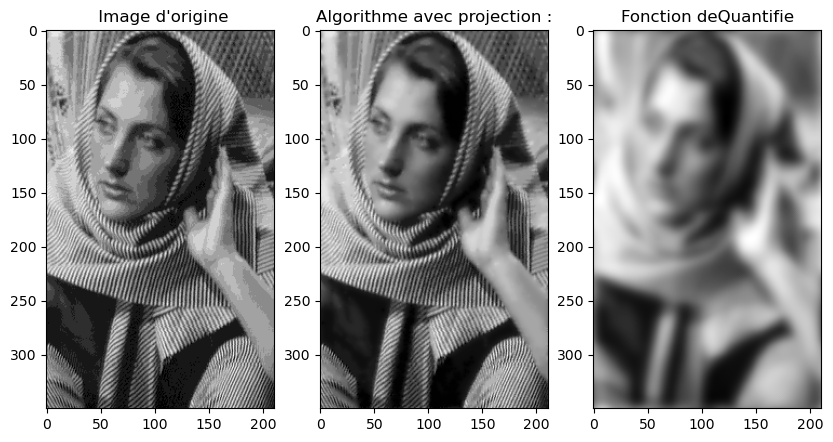

Lambda:  0.1
Temps d'execution pour l'algorithme deQuantifie pour Lambda= 0.1  4.698125123977661


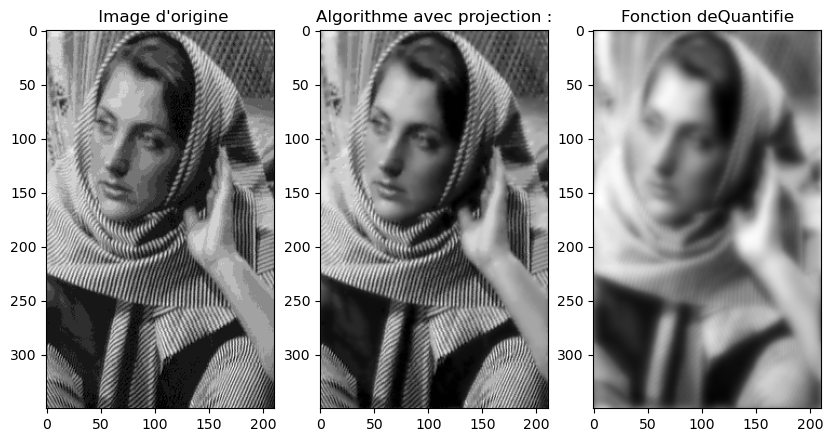

Lambda:  1
Temps d'execution pour l'algorithme deQuantifie pour Lambda= 1  4.7465291023254395


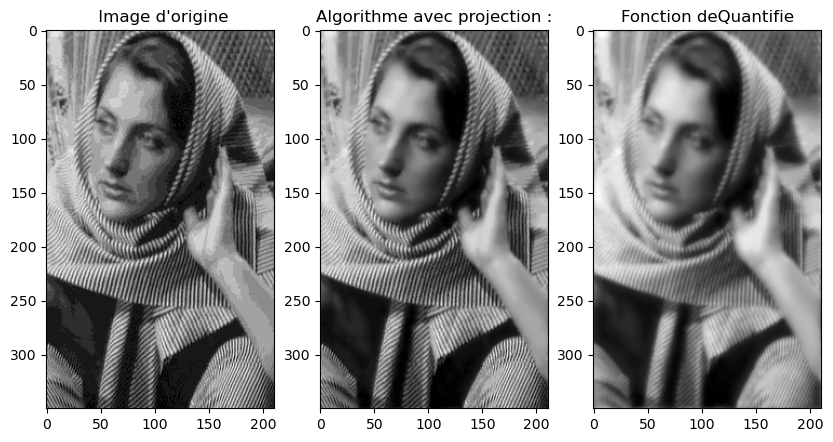

Lambda:  10
Temps d'execution pour l'algorithme deQuantifie pour Lambda= 10  4.710490942001343


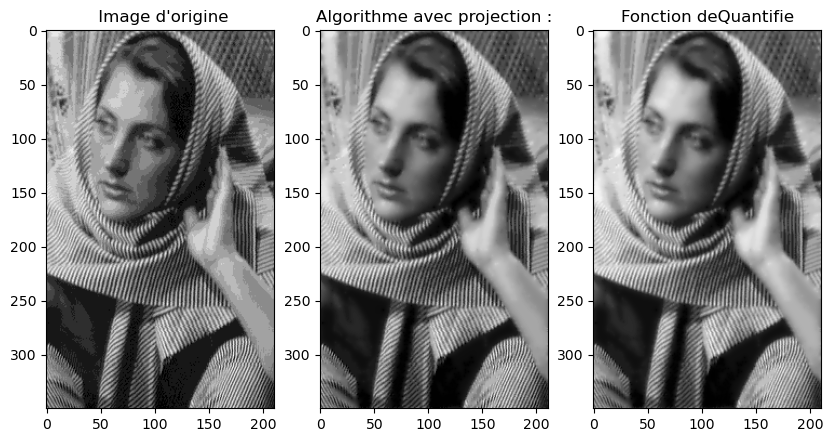

In [24]:
tau = 20
v = quantifie_image(u,tau)

Lambda=[0.01 , 0.1 , 1 , 10]
for lamb in Lambda :
    print("Lambda: ",lamb)
    

    proj_t0=time.time()
    proj = grad_proj(v,tau,50,1/(8+2*lamb))
    proj_t1=time.time()

print("Temps d'execution pour l'algorithme avec projection :", proj_t1-proj_t0)
Lambda=[0.01 , 0.1 , 1 , 10]
for lbd in Lambda :
    print("Lambda: ",lbd)
    
    t0=time.time()
    out = deQuantifie(v,tau,lbd,50)
    t1=time.time()
    
    print("Temps d'execution pour l'algorithme deQuantifie pour Lambda= "+str(lbd) +" ", t1-t0)
    
    plt.figure(figsize = (10,15))
    plt.subplot(2,3,1)
    plt.title(" Image d'origine")
    plt.imshow(v,cmap='gray')
    plt.subplot(2,3,2)
    plt.title("Algorithme avec projection :")
    plt.imshow(proj,cmap='gray')
    plt.subplot(2,3,3)
    plt.title("Fonction deQuantifie")
    plt.imshow(out,cmap='gray')
    plt.show()

D'un point de vue de performance, nous constatons que la fonction deQuantifie est plus rapide que notre algorithme avec projection, quel que soit le paramètre lambda utilisé.

Cependant, en examinant les résultats visuels, nous observons que l'image produite par l'algorithme avec projection est nettement plus fidèle à l'image d'origine et présente moins de flou, même pour les valeurs de lambda les plus élevées.

De plus, il est important de noter que pour de faibles valeurs de lambda, la fonction deQuantifie ne fournit pas des résultats optimaux, tandis que l'algorithme du gradient projeté est indépendant du paramètre lambda.

En outre, il semble que le nombre d'itérations nécessaires pour obtenir une image de qualité déquantifiée soit minimal avec le second algorithme.

En conclusion, si l'on devait choisir un algorithme, l'algorithme avec projection serait préféré dans la plupart des cas, à moins qu'un très grand nombre d'itérations ne soit requis. Dans ce cas-là seulement, la fonction deQuantifie serait privilégiée.